# Unsupervised Learning

This section marks our journey into another significant domain of machine learning and AI: unsupervised learning. Rather than delving deep into theoretical intricacies, our focus here will be on offering a practical guide. We aim to equip you with a clear understanding and effective tools for employing unsupervised learning methods in real-world (EO) scenarios.

It's important to note that, while unsupervised learning encompasses a broad range of applications, our discussion will predominantly revolve around classification tasks. This is because unsupervised learning techniques are exceptionally adept at identifying patterns and categorising data when the classifications are not explicitly labeled. By exploring these techniques, you'll gain insights into how to discern structure and relationships within your datasets, even in the absence of predefined categories or labels.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 43.9 MB/s eta 0:00:00


In [7]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.9 MB/s eta 0:00:00


## Altimetry Classification

### Read in Functions Needed
Before delving into the modeling process, it's crucial to preprocess the data to ensure compatibility with our analytical models. This involves transforming the raw data into meaningful variables, such as peakniness and stack standard deviation (SSD), etc.

In [8]:
#
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

# stack standard deviation
def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    # from scipy import asarray as ar,exp
    from numpy import asarray as ar, exp

    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD


In [9]:
# Specify your unique path to the folder where Sentinel data is
path = '/content/drive/MyDrive/AI4EO/Week4/Unsupervised Learning/'
SAR_file = 'S3A_SR_2_LAN_SI_20190307T005808_20190307T012503_20230527T225016_1614_042_131______LN3_R_NT_005.SEN3'
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
waves   = unpack_gpod('waveform_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')
RIP     = unpack_gpod('rip_20_ku')
flag = unpack_gpod('surf_type_class_20_ku')

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find]
RIP     = RIP[find]

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

# Create data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

Running peakiness function...


<ipython-input-8-c11387676558>:63: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


There are some NaN values in the dataset so one way to deal with this is to delete them.

In [10]:
# Remove any rows that contain NaN values
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]

mask = ~np.isnan(data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]


Number of NaN values in the array: 1283


In [11]:
# Check the shape of array 'waves'
waves.shape

# The output means 'wave's is a 2D array with 24 827 rows and 256 columns

(24827, 256)

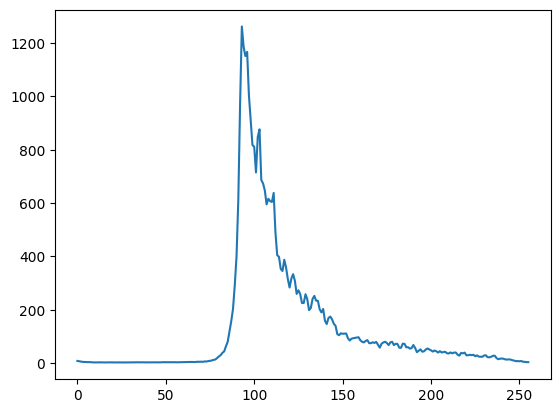

In [12]:
# Plot the 10000th echo, the data from the 10000th row of the waves array
plt.plot(waves[10000,:])

# The ouput signifies a lead, since it is very peaky

In [13]:
# Check the shape of array 'waves_cleaned'
waves_cleaned.shape

# The number of rows is smaller because we removed rows with NaN values and filtered out rows where flag_cleaned is not 1 or 2.

(12195, 256)

In [14]:
# Check the shape of array 'data_cleaned'
data_cleaned.shape

(12195, 3)

In [15]:
# Check the shape of array 'flag_cleaned'
flag_cleaned.shape

(12195,)

## GMM

In [16]:
# Apply the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

In [17]:
# Check the labels, they match size of '*_cleaned'
clusters_gmm.shape

(12195,)

We can also inspect how many data points are there in each class of your clustering prediction.

In [49]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

# From the outputs: 8880 pixels classified as sea ice, 3315 pixels classified as leads

Cluster counts: {0: 8880, 1: 3315}


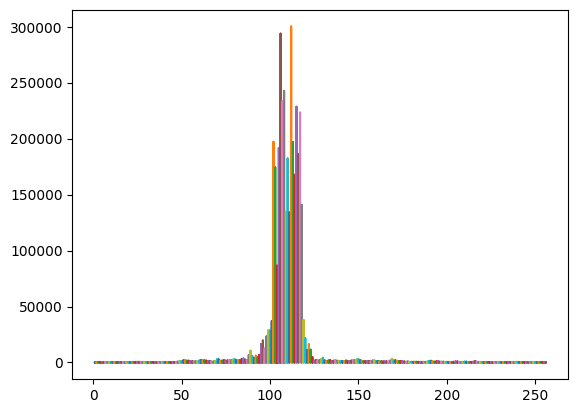

In [20]:
# Plot of all the echos, both sea ice and leads
x = np.stack([np.arange(1,waves_cleaned.shape[1]+1)]*waves_cleaned.shape[0])
plt.plot(x,waves_cleaned)
plt.show()

# Leads are so intense compared to ice, in this plot you can only see leads even though ice is also plotted

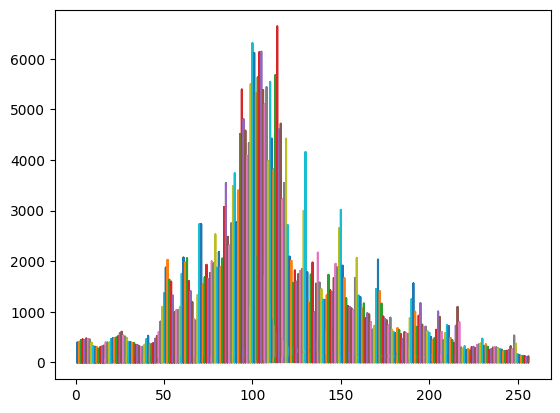

In [21]:
# Plot echos only for the sea ice cluster (clusters_gmm==0)
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==0].shape[1]+1)]*waves_cleaned[clusters_gmm==0].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==0])
plt.show()

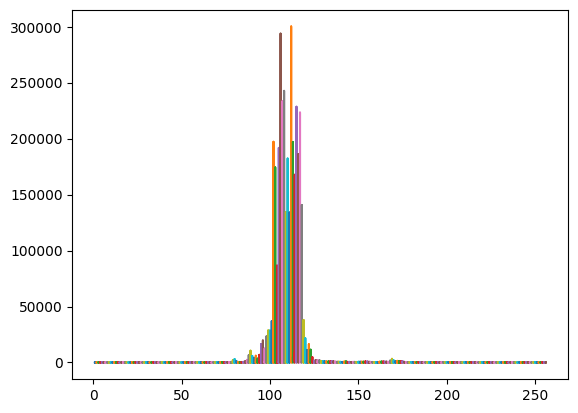

In [22]:
# Plot of echos only for the lead cluster (clusters_gmm==1)
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==1].shape[1]+1)]*waves_cleaned[clusters_gmm==1].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==1])
plt.show()

To make the plots easier to interpret, only 10 equally spaced functions of each cluster (sea ice and leads) are extracted and the analysis is done on those.

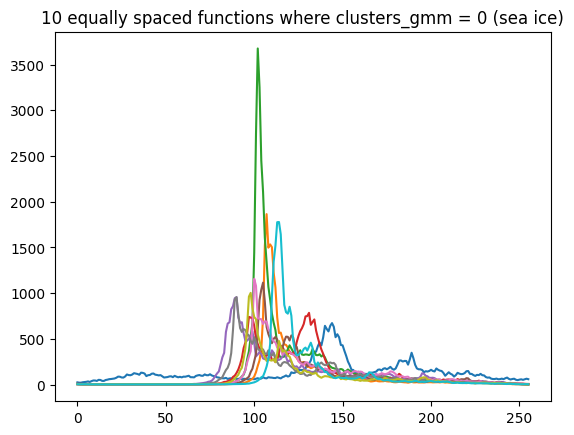

In [25]:
# Extract 10 equally spaced functions where clusters_gmm = 0 (sea ice)
functions_to_plot = waves_cleaned[clusters_gmm == 0][::len(waves_cleaned[clusters_gmm == 0]) // 10]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function), #label=f'Function {i+1}')

plt.title('10 equally spaced functions where clusters_gmm = 0 (sea ice)')
plt.show()

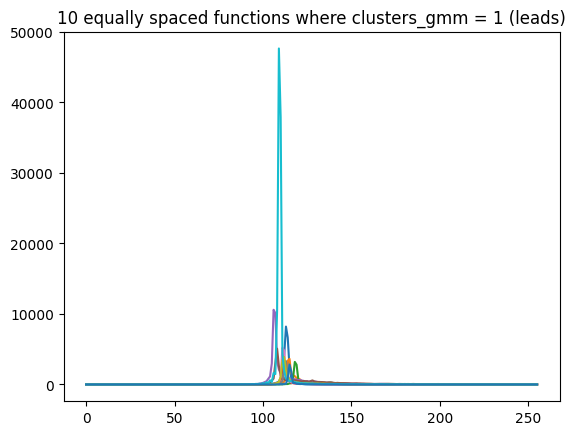

In [26]:
# Extract 10 equally spaced functions where clusters_gmm = 1 (leads)
functions_to_plot = waves_cleaned[clusters_gmm == 1][::len(waves_cleaned[clusters_gmm == 1]) // 10]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function), #label=f'Function {i+1}')

plt.title('10 equally spaced functions where clusters_gmm = 1 (leads)')
plt.show()

## Waveform Alignment Using Cross-Correlation

This code aligns waveforms in the cluster by using cross-correlation.



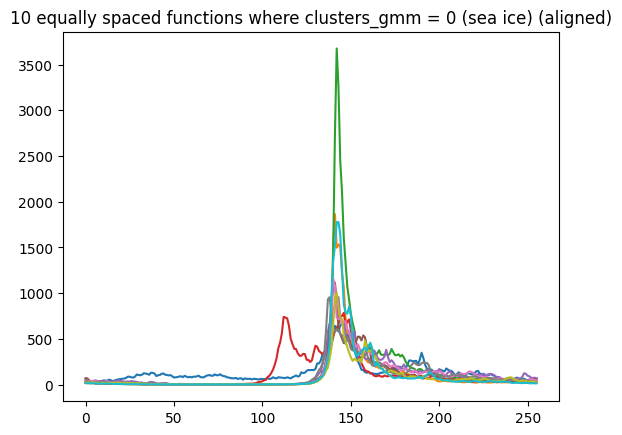

In [27]:
# Shift the functions so the echo peaks are aligned
from scipy.signal import correlate

# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_gmm==0], axis=0))

# Calculate cross-correlation with the reference point
aligned_waves = []
for wave in waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave_0 = np.roll(wave, shift)
    aligned_waves.append(aligned_wave_0)

# Plot aligned waves
for aligned_wave_0 in aligned_waves:
    plt.plot(aligned_wave_0)

plt.title('10 equally spaced functions where clusters_gmm = 0 (sea ice) (aligned)')
plt.show()

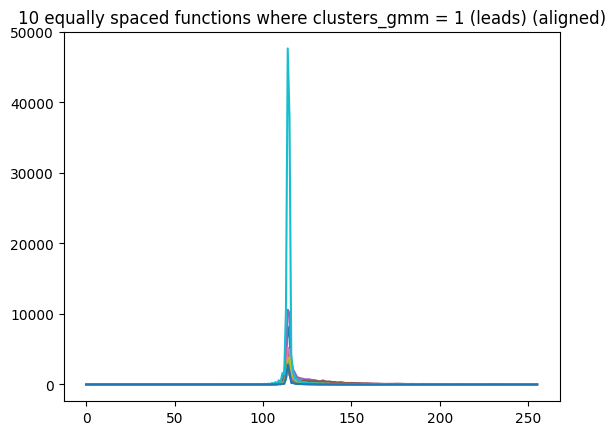

In [31]:
# Shift the functions so the echo peaks are aligned
from scipy.signal import correlate

# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_gmm==1], axis=0))

# Calculate cross-correlation with the reference point
aligned_waves = []
for wave in waves_cleaned[clusters_gmm==1][::len(waves_cleaned[clusters_gmm == 1]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==1][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave_1 = np.roll(wave, shift)
    aligned_waves.append(aligned_wave_1)

# Plot aligned waves
for aligned_wave_1 in aligned_waves:
    plt.plot(aligned_wave_1)

plt.title('10 equally spaced functions where clusters_gmm = 1 (leads) (aligned)')
plt.show()

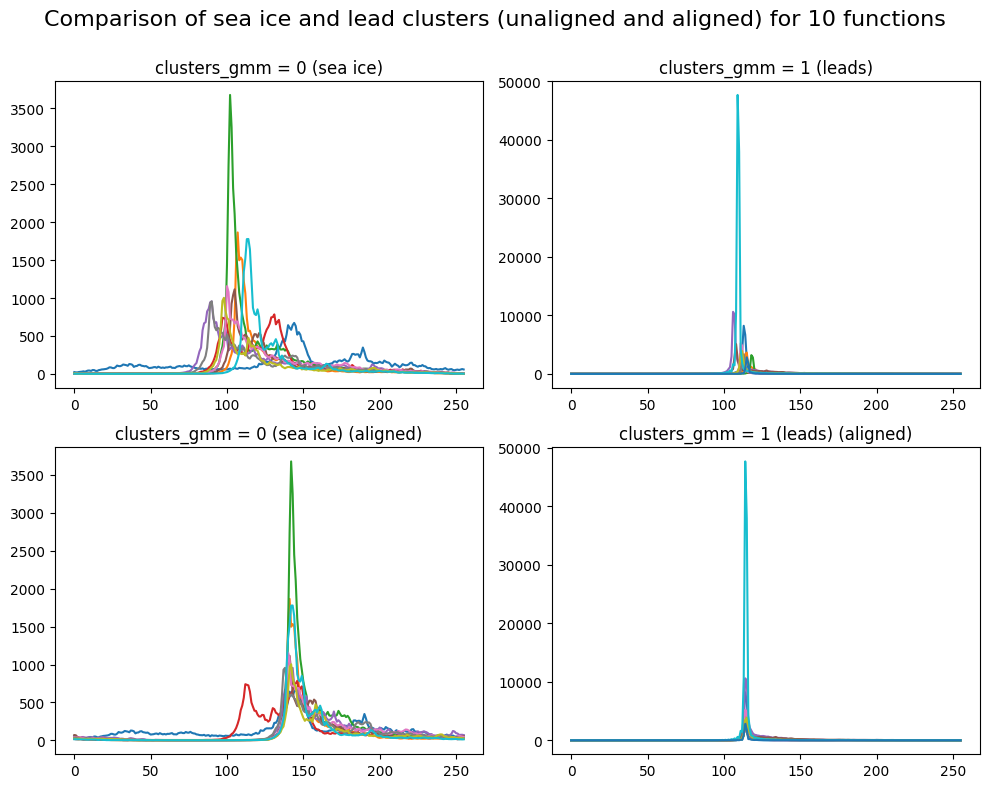

In [32]:
# COMBINED PLOT
# Present clusters_gmm = 0 and clusters_gmm = 1, aligned and not, next to each other
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate

# Subplot with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot clusters_gmm = 0 (not aligned)
functions_to_plot_0 = waves_cleaned[clusters_gmm == 0][::len(waves_cleaned[clusters_gmm == 0]) // 10]
for i, function in enumerate(functions_to_plot_0):
    axs[0, 0].plot(function, label=f'Function {i+1}')
axs[0, 0].set_title('clusters_gmm = 0 (sea ice)')
# axs[0, 0].legend()

# Plot clusters_gmm = 1 (not aligned)
functions_to_plot_1 = waves_cleaned[clusters_gmm == 1][::len(waves_cleaned[clusters_gmm == 1]) // 10]
for i, function in enumerate(functions_to_plot_1):
    axs[0, 1].plot(function, label=f'Function {i+1}')
axs[0, 1].set_title('clusters_gmm = 1 (leads)')
# axs[0, 1].legend()

# Plot clusters_gmm = 0 (aligned)
reference_point_index_0 = np.argmax(np.mean(waves_cleaned[clusters_gmm == 0], axis=0))
aligned_waves_0 = []
for wave in waves_cleaned[clusters_gmm == 0][::len(waves_cleaned[clusters_gmm == 0]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm == 0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave_0 = np.roll(wave, shift)
    aligned_waves_0.append(aligned_wave_0)
for aligned_wave_0 in aligned_waves_0:
    axs[1, 0].plot(aligned_wave_0)
axs[1, 0].set_title('clusters_gmm = 0 (sea ice) (aligned)')

# Plot clusters_gmm = 1 (aligned)
reference_point_index_1 = np.argmax(np.mean(waves_cleaned[clusters_gmm == 1], axis=0))
aligned_waves_1 = []
for wave in waves_cleaned[clusters_gmm == 1][::len(waves_cleaned[clusters_gmm == 1]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm == 1][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave_1 = np.roll(wave, shift)
    aligned_waves_1.append(aligned_wave_1)
for aligned_wave_1 in aligned_waves_1:
    axs[1, 1].plot(aligned_wave_1)
axs[1, 1].set_title('clusters_gmm = 1 (leads) (aligned)')

# Add a title for all subplots
fig.suptitle('Comparison of sea ice and lead clusters (unaligned and aligned) for 10 functions', fontsize=16)

# Show the plots
plt.tight_layout()
plt.subplots_adjust(top=0.89)
plt.show()


We can plot the mean waveform of each class.

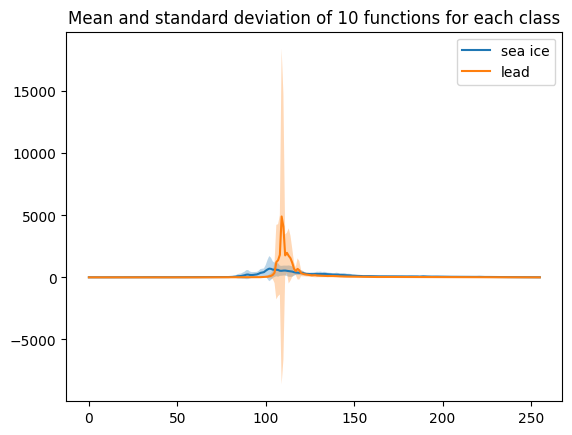

In [34]:
# Mean and standard deviation for 10 echoes for each class
mean_ice = np.mean(waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10], axis=0)

plt.plot(mean_ice, label='sea ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

# plt.fill_between shades the area between the mean ± standard deviation
# Choosing alpha=0.3 ensures proper transparency for the shaded areas

mean_lead = np.mean(waves_cleaned[clusters_gmm==1][::len(waves_cleaned[clusters_gmm == 1]) // 10],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1][::len(waves_cleaned[clusters_gmm == 1]) // 10], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Mean and standard deviation of 10 functions for each class')
plt.legend()

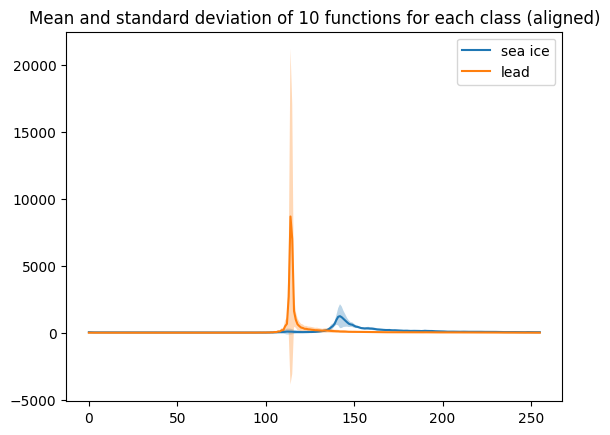

In [35]:
# Mean and standard deviation for 10 echoes for each class (aligned)
mean_ice = np.mean(aligned_waves_0[::len(aligned_waves_0) // 10],axis=0)
std_ice = np.std(aligned_waves_0[::len(aligned_waves_0) // 10], axis=0)

plt.plot(mean_ice, label='sea ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

# plt.fill_between shades the area between the mean ± standard deviation
# Choosing alpha=0.3 ensures proper transparency for the shaded areas

mean_lead = np.mean(aligned_waves_1[::len(aligned_waves_1) // 10],axis=0)
std_lead = np.std(aligned_waves_1[::len(aligned_waves_1) // 10], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Mean and standard deviation of 10 functions for each class (aligned)')
plt.legend()

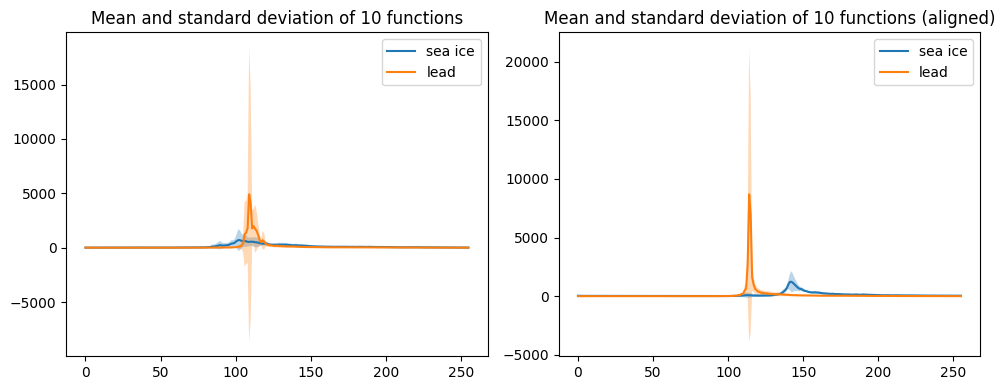

In [40]:
# Comparison of unaligned vs aligned mean and standard deviation

# Create the subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Mean and standard deviation for 10 echoes for each class
mean_ice = np.mean(waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10], axis=0)
axs[0].plot(mean_ice, label='sea ice')
axs[0].fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)
mean_lead = np.mean(waves_cleaned[clusters_gmm==1][::len(waves_cleaned[clusters_gmm == 1]) // 10],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1][::len(waves_cleaned[clusters_gmm == 1]) // 10], axis=0)
axs[0].plot(mean_lead, label='lead')
axs[0].fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)
axs[0].set_title('Mean and standard deviation of 10 functions')
axs[0].legend()

# Mean and standard deviation for 10 echoes for each class (aligned)
mean_ice_a = np.mean(aligned_waves_0[::len(aligned_waves_0) // 10],axis=0)
std_ice_a = np.std(aligned_waves_0[::len(aligned_waves_0) // 10], axis=0)
axs[1].plot(mean_ice_a, label='sea ice')
axs[1].fill_between(range(len(mean_ice_a)), mean_ice_a - std_ice_a, mean_ice_a + std_ice_a, alpha=0.3)
mean_lead_a = np.mean(aligned_waves_1[::len(aligned_waves_1) // 10],axis=0)
std_lead_a = np.std(aligned_waves_1[::len(aligned_waves_1) // 10], axis=0)
axs[1].plot(mean_lead_a, label='lead')
axs[1].fill_between(range(len(mean_lead_a)), mean_lead_a - std_lead_a, mean_lead_a + std_lead_a, alpha=0.3)
axs[1].set_title('Mean and standard deviation of 10 functions (aligned)')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

To make it easier to analyse the mean and standard deviation, now all echoes are plotted.

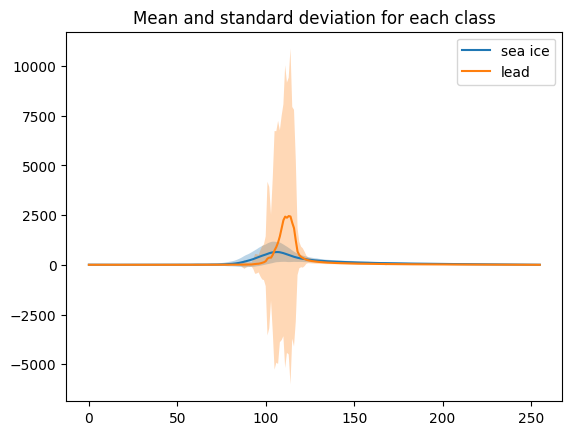

In [41]:
# Mean and standard deviation for all echoes
mean_ice = np.mean(waves_cleaned[clusters_gmm==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0], axis=0)

plt.plot(mean_ice, label='sea ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

mean_lead = np.mean(waves_cleaned[clusters_gmm==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Mean and standard deviation for each class')
plt.legend()

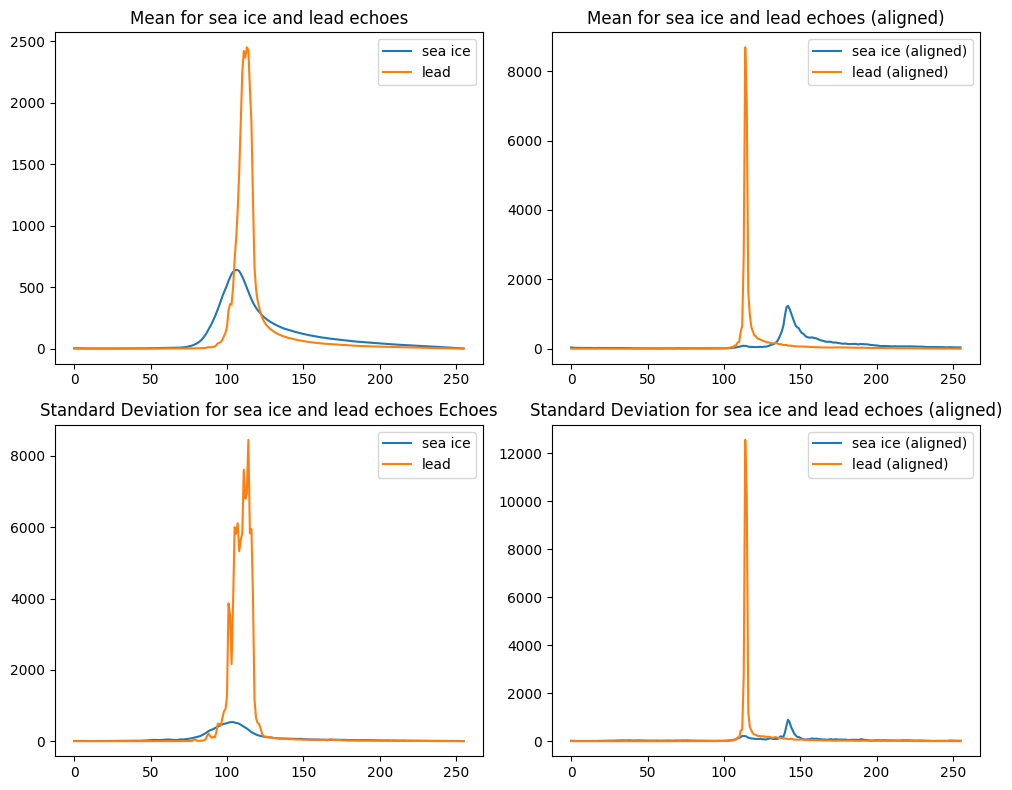

In [42]:
# Separated means and standard deviations for sea ice and leads, unaligned and aligned

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Find the reference point for sea ice and leads clusters
reference_point_index_0 = np.argmax(np.mean(waves_cleaned[clusters_gmm==0], axis=0))
reference_point_index_1 = np.argmax(np.mean(waves_cleaned[clusters_gmm==1], axis=0))

# Align the sea ice (cluster 0)
aligned_waves_0 = []
for wave in waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave_0 = np.roll(wave, shift)
    aligned_waves_0.append(aligned_wave_0)

# Align the leads (cluster 1)
aligned_waves_1 = []
for wave in waves_cleaned[clusters_gmm==1][::len(waves_cleaned[clusters_gmm == 1]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==1][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave_1 = np.roll(wave, shift)
    aligned_waves_1.append(aligned_wave_1)

# Create the subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the mean waves for sea ice and lead echoes
axs[0, 0].plot(np.mean(waves_cleaned[clusters_gmm == 0], axis=0), label='sea ice')
axs[0, 0].plot(np.mean(waves_cleaned[clusters_gmm == 1], axis=0), label='lead')
axs[0, 0].set_title('Mean for sea ice and lead echoes')
axs[0, 0].legend()

# Plot the mean waves for sea ice and lead echoes (aligned)
axs[0, 1].plot(np.mean(aligned_waves_0, axis=0), label='sea ice (aligned)')
axs[0, 1].plot(np.mean(aligned_waves_1, axis=0), label='lead (aligned)')
axs[0, 1].set_title('Mean for sea ice and lead echoes (aligned)')
axs[0, 1].legend()

# Plot the standard deviation for sea ice and lead echoes
axs[1, 0].plot(np.std(waves_cleaned[clusters_gmm == 0], axis=0), label='sea ice')
axs[1, 0].plot(np.std(waves_cleaned[clusters_gmm == 1], axis=0), label='lead')
axs[1, 0].set_title('Standard Deviation for sea ice and lead echoes Echoes')
axs[1, 0].legend()

# Plot the standard deviation for sea ice and lead echoes (aligned)
axs[1, 1].plot(np.std(aligned_waves_0, axis=0), label='sea ice (aligned)')
axs[1, 1].plot(np.std(aligned_waves_1, axis=0), label='lead (aligned)')
axs[1, 1].set_title('Standard Deviation for sea ice and lead echoes (aligned)')
axs[1, 1].legend()


# Show the plot
plt.tight_layout()
plt.show()


## Scatter Plots of Clustered Data

This code visualizes the clustering results using scatter plots, where different colors represent different clusters (`clusters_gmm`).

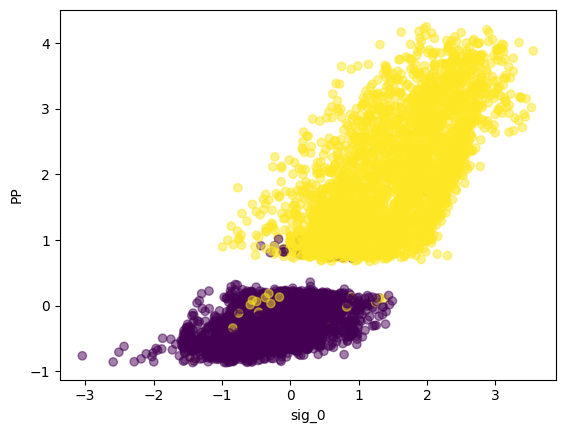

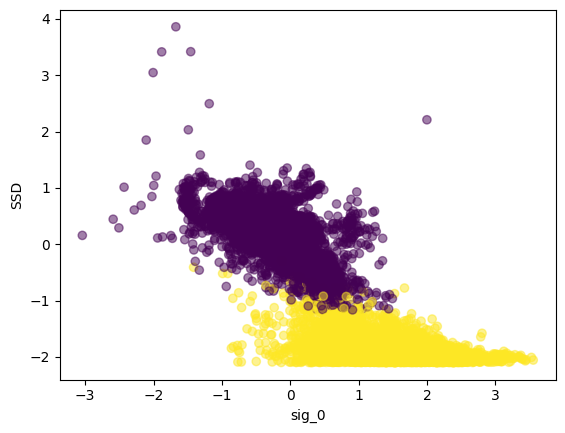

Text(0, 0.5, 'SSD')

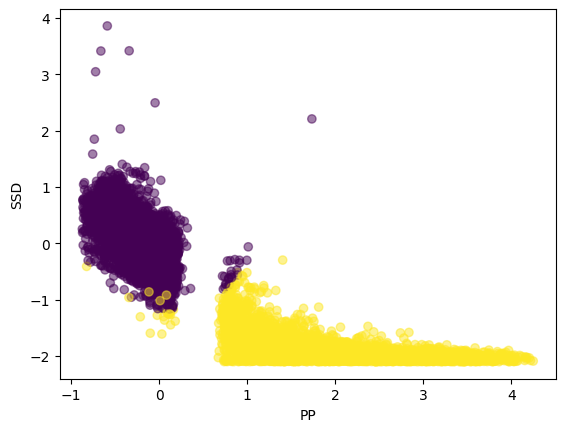

In [43]:
plt.scatter(data_cleaned[:,0],data_cleaned[:,1],c=clusters_gmm,alpha=0.5) # alpha adjusts transparency
plt.xlabel("sig_0")
plt.ylabel("PP")
plt.show()
plt.scatter(data_cleaned[:,0],data_cleaned[:,2],c=clusters_gmm,alpha=0.5)
plt.xlabel("sig_0")
plt.ylabel("SSD")
plt.show()
plt.scatter(data_cleaned[:,1],data_cleaned[:,2],c=clusters_gmm,alpha=0.5)
plt.xlabel("PP")
plt.ylabel("SSD")

# Leads are yellow, they are peakier and have higher values
# Sea ice is purple, less peaky and with lower values

## Compare with ESA data
In the ESA dataset, sea ice = 1 and lead = 2. Therefore, we need to subtract 1 from it so our predicted labels are comparable with the official product labels.

In [46]:
# Indexing adjustment: the data uses categories starting from 1, but the learning algorithm
# expects categories starting from 0, so this aligns the labels properly
flag_cleaned_modified = flag_cleaned - 1

Confusion Matrix:
[[8856   22]
 [  24 3293]]


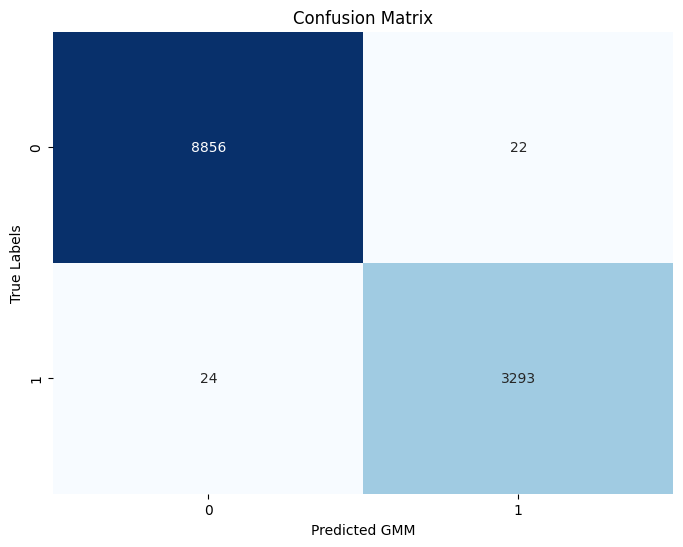


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8878
         1.0       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195



In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

true_labels = flag_cleaned_modified   # true labels from the ESA dataset
predicted_gmm = clusters_gmm          # predicted labels from GMM method

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_gmm)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_gmm)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted GMM")
plt.ylabel("True Labels")
plt.show()

# Compute classification report
class_report = classification_report(true_labels, predicted_gmm)

# Print classification report
print("\nClassification Report:")
print(class_report)